# Modeling

![alt text](./images/USA_zones.png)
<center>(Figure 1) Impact Zones</center>

Import modules

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.models import model_from_json
import matplotlib.pyplot as plt
import seaborn as sns

Loading data

In [84]:
def load_data():
    # Returns dataframe of preprocessed hurricane data
    df = pd.read_csv('./data/hurdat2_preprocessed.csv')
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

Calculating independent and dependent variables

In [85]:
def Xy(df):
    # Return independent and dependent variables
    cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    X = df.drop(cols, axis=1)
    y = df[cols]
    return(X, y)

Train test split

In [86]:
def ttsplit(X, y):
    # Returns training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True)
    return(X_train, X_test, y_train, y_test)

Oversampling the minority class

In [87]:
def resample(X, y):
    # Returns X and y with oversampled minority class
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_sample(X, y)    
    return(X_resampled, y_resampled)

Separating Hurricanes Irma and Harvey data for later model evaluation

In [88]:
df = load_data()
irma_harvey = df.iloc[-85:]
irma_harvey.to_csv('./data/irma_harvey.csv')
df = df.iloc[:-85]

Initializing dictionaries

In [89]:
Xtrain = {}
Xtest = {}
ytrain = {}
ytest = {}
baseline = {}

Calculating training and test data sets

In [90]:
for zone in 'ABCDEFGHIJK':
    print('Preparing Zone {} data ...'.format(zone))
    df = load_data()
    X, y = Xy(df)
    X_train, X_test, y_train, y_test = ttsplit(X, y)
    X_train_resampled, y_train_resampled = resample(X_train, y_train[zone])
    ss = StandardScaler()
    X_train_resampled_ss = ss.fit_transform(X_train_resampled)
    X_test_ss = ss.transform(X_test)
    Xtrain[zone] = X_train_resampled_ss
    Xtest[zone] = X_test_ss
    ytrain[zone] = y_train_resampled
    ytest[zone] = y_test[zone]
    baseline[zone] = 1 - y[zone].sum() / y[zone].count()

Preparing Zone A data ...
Preparing Zone B data ...
Preparing Zone C data ...
Preparing Zone D data ...
Preparing Zone E data ...
Preparing Zone F data ...
Preparing Zone G data ...
Preparing Zone H data ...
Preparing Zone I data ...
Preparing Zone J data ...
Preparing Zone K data ...


What is the baseline for each zone?

In [91]:
for zone in 'ABCDEFGHIJK':
    print('Baseline for Zone {} is {}%'.format(zone, round(baseline[zone] * 100, 1)))

Baseline for Zone A is 96.8%
Baseline for Zone B is 93.6%
Baseline for Zone C is 92.6%
Baseline for Zone D is 92.1%
Baseline for Zone E is 86.6%
Baseline for Zone F is 91.1%
Baseline for Zone G is 90.1%
Baseline for Zone H is 85.8%
Baseline for Zone I is 83.1%
Baseline for Zone J is 87.4%
Baseline for Zone K is 91.1%


Initialize neural network

In [92]:
def begin_neural_net(n_inputs):
    # Returns initialized keras object
    model = Sequential()
    hidden_units = n_inputs
    return model

Define neural network's topology

In [93]:
def topology(model, n_inputs):
    # Returns keras object
    model.add(Dense(n_inputs,
                    input_dim=n_inputs,
                    activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_inputs + 30,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(12,
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Saving model and weights

In [94]:
def save_model(model, zone):
    # Saves neural net and weights
    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = model.to_json()
    with open('./models/' + zone + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('./models/' + zone + '.h5')

Generates graph of model's loss function value

In [95]:
def plot_loss(hist, zone):
    # Returns plot of loss function vs epochs
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Zone {} loss'.format(zone))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
    plt.show()    

Generates graph of model's accuracy 

In [96]:
def plot_acc(hist, zone):
    # Returns plot of accuracy vs epochs
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Zone {} accuracy'.format(zone))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    hist.history['val_acc'][-1]

Plotting style

In [97]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}
sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Training neural networks for each zone

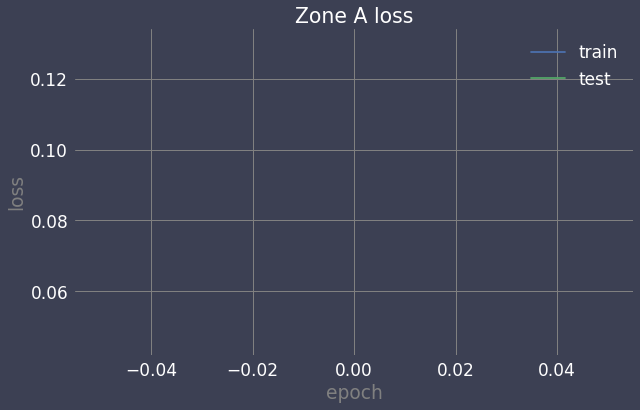

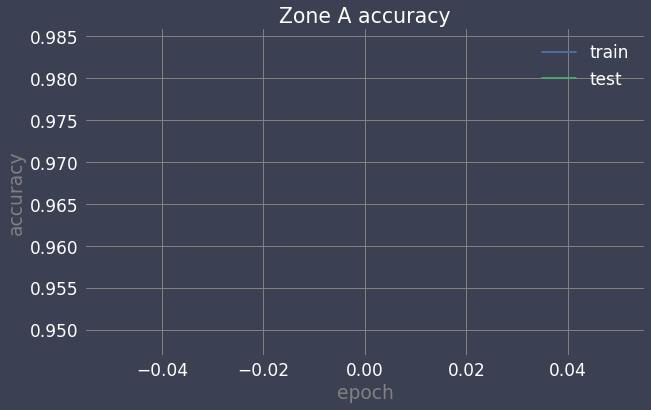

*** Zone A ***
    Actual  Predicted
0        0          0
1        0          0
2        0          0
3        0          0
4        0          0
5        0          0
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
12       0          0
13       0          0
14       0          0
15       0          0
16       0          0
17       0          0
18       0          0
19       0          0
20       0          0
21       0          0
22       0          0
23       0          0
24       0          0
25       0          1
26       0          1
27       0          1
28       0          1
29       0          1
30       0          1
31       0          1
32       0          1
33       0          1
34       0          1
35       0          1
36       0          1
37       0          1
38       0          1
39       0          1
40       0          1
41       0          1
42       0          1
43       0       

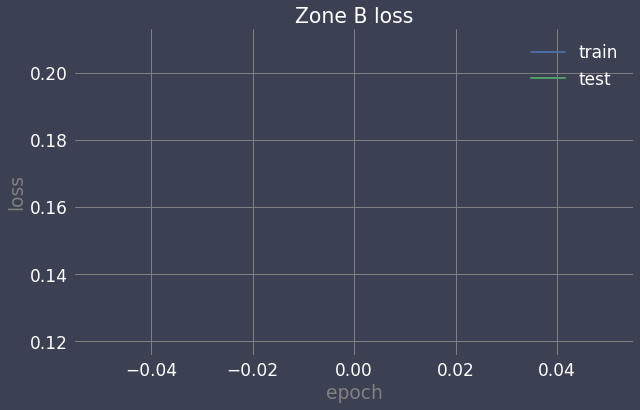

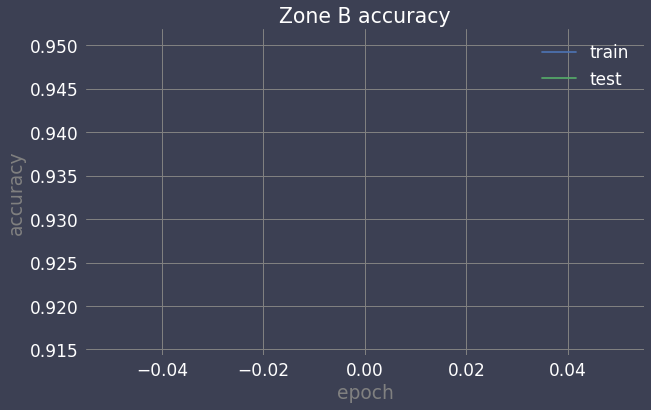

*** Zone B ***
    Actual  Predicted
0        0          0
1        0          0
2        0          0
3        0          0
4        0          0
5        0          0
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
12       0          0
13       0          0
14       0          0
15       0          0
16       0          0
17       0          0
18       0          0
19       0          0
20       0          0
21       0          0
22       0          0
23       0          0
24       0          0
25       0          0
26       0          1
27       0          1
28       0          1
29       0          1
30       0          1
31       0          1
32       0          1
33       0          1
34       0          1
35       0          1
36       0          1
37       0          1
38       0          1
39       0          1
40       0          1
41       0          1
42       0          1
43       0       

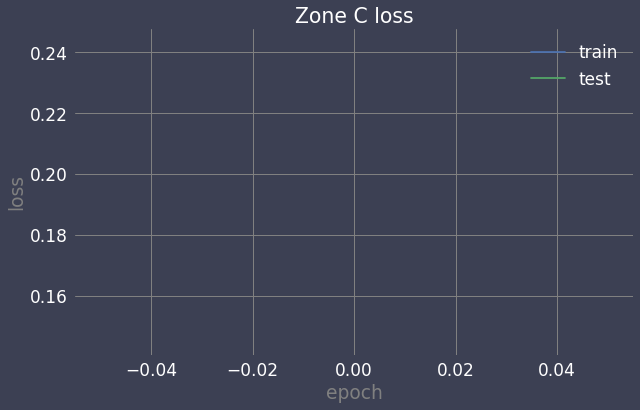

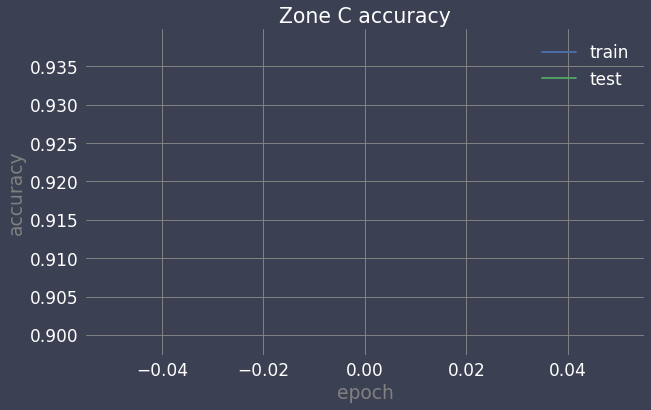

KeyboardInterrupt: 

In [127]:
neural_net = {}
F1_scores = {}
irma_harvey_preds = {}
for zone in 'ABCDEFGHIJK':
    # Initialize model
    n_inputs = Xtrain[zone].shape[1]
    model = begin_neural_net(n_inputs)
    model = topology(model, n_inputs)
    # Compile
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    # Train model
    hist = model.fit(Xtrain[zone],
                     ytrain[zone],
                     validation_data=(Xtest[zone], ytest[zone]),
                     epochs=1000,
                     batch_size=256,
                     shuffle=True,
                     verbose=0)
    # Saving results
    save_model(model, zone)
    neural_net[zone] = model
    # Ploting results
    plot_loss(hist, zone)
    plot_acc(hist, zone)
    # F1 score on test set
    F1_scores[zone] = metrics.f1_score(ytest[zone], np.round(model.predict(Xtest[zone])))
    # Predictions for Hurricanes Irma and Harvey
    irma_harvey_X = ss.transform(irma_harvey.drop(cols, axis=1))
    irma_harvey_preds[zone] = np.ravel(model.predict_classes(irma_harvey_X))
    # Printing predictions
    print('*** Zone {} ***'.format(zone))
    print(pd.DataFrame(list(zip(irma_harvey[zone], irma_harvey_preds[zone])),
          columns=['Actual', 'Predicted']))
    print('')